In [2]:
import numpy as np
import sklearn.ensemble._forest as forest_utils
from sklearn import tree
from sklearn.tree import DecisionTreeRegressor, plot_tree
from sklearn.ensemble import RandomForestRegressor
from sklearn.datasets import load_iris

In [3]:
iris = load_iris()
X, y = iris.data, iris.target

rf = RandomForestRegressor(random_state=140902, max_depth=1)
rf.fit(X,y)

RandomForestRegressor(max_depth=1, random_state=140902)

In [4]:
trees = rf.estimators_

In [5]:
# Get the indices of samples used in each tree
samples_used = rf.estimators_samples_

In [6]:
samplesidx = set()
for samples in samples_used:
    for sampleidx in samples:
        samplesidx.add(sampleidx)
samplesidx = list(samplesidx)
print(f'LENGTH: {len(samplesidx)}')

LENGTH: 150


In [7]:
def get_unions(X, y, samples_used_idx):
    return X[samples_used_idx], y[samples_used_idx]

X_union, y_union = get_unions(X, y, samplesidx)

In [8]:
print(f'X_union length: {len(X_union)} | y_union length: {len(y_union)}')

X_union length: 150 | y_union length: 150


[Text(0.5, 0.75, 'x[2] <= 2.45\nsquared_error = 0.653\nsamples = 100\nvalue = 1.027'),
 Text(0.25, 0.25, 'squared_error = 0.0\nsamples = 32\nvalue = 0.0'),
 Text(0.375, 0.5, 'True  '),
 Text(0.75, 0.25, 'squared_error = 0.25\nsamples = 68\nvalue = 1.495'),
 Text(0.625, 0.5, '  False')]

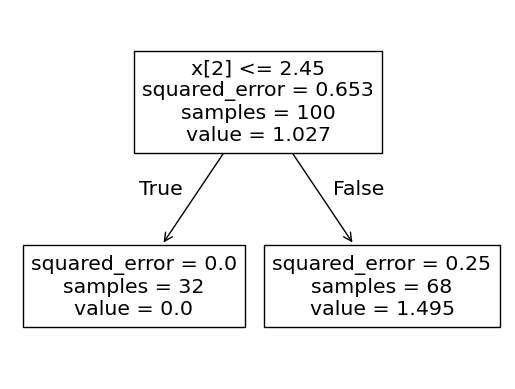

In [9]:
test_tree = trees[0]
plot_tree(test_tree)

In [10]:
f'{test_tree.tree_.feature[0]} | {test_tree.tree_.threshold[0]}'
test_tree.tree_.capacity

3

In [11]:
def merge_trees(trees, X_union, y_union):
    new_tree = DecisionTreeRegressor(max_depth=10)
    new_tree.fit(X_union, y_union)
    rv_tree = new_tree.tree_

    def merger(trees, tree, current_node, depth=0):
        if depth >= len(trees) or current_node >= tree.capacity:
            return
        source_tree = trees[depth].tree_
        used_feature, used_threshold = source_tree.feature[0], source_tree.threshold[0]
        left_child, right_child = current_node + 1, current_node + 2

        if left_child < tree.capacity and right_child < tree.capacity:
            tree.children_left[current_node] = left_child
            tree.children_right[current_node] = right_child

            merger(trees, tree, left_child, depth + 1)
            merger(trees, tree, right_child, depth + 1)
    
    merger(trees, rv_tree, 0)
    return new_tree

In [12]:
trees_test = trees[:2]

In [13]:
new_tree = DecisionTreeRegressor(max_depth=2)
new_tree.fit(X_union, y_union)
rv_tree = new_tree.tree_

[Text(0.4, 0.8333333333333334, 'x[3] <= 0.8\nsquared_error = 0.667\nsamples = 150\nvalue = 1.0'),
 Text(0.2, 0.5, 'squared_error = 0.0\nsamples = 50\nvalue = 0.0'),
 Text(0.30000000000000004, 0.6666666666666667, 'True  '),
 Text(0.6, 0.5, 'x[3] <= 1.75\nsquared_error = 0.25\nsamples = 100\nvalue = 1.5'),
 Text(0.5, 0.6666666666666667, '  False'),
 Text(0.4, 0.16666666666666666, 'squared_error = 0.084\nsamples = 54\nvalue = 1.093'),
 Text(0.8, 0.16666666666666666, 'squared_error = 0.021\nsamples = 46\nvalue = 1.978')]

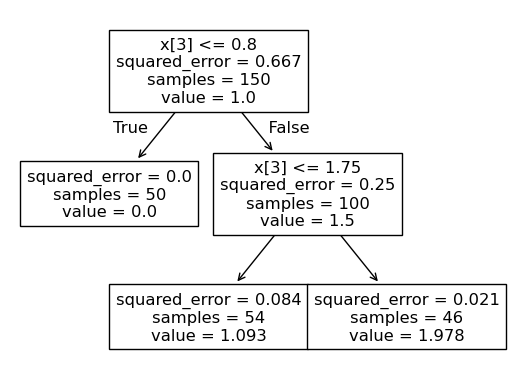

In [14]:
plot_tree(new_tree)

In [15]:
class Node:
    def __init__(self, feature=None, threshold=None, left=None, right=None, value=None):
        self.feature = feature
        self.threshold = threshold
        self.left = left
        self.right = right
        self.value = value

class TreeCombiner:
    def __init__(self, trees):
        self.trees = trees
        self.root = Node()
    
    def combine_two(self):
        self.root.feature = self.trees[0].tree_.feature[0]
        self.root.threshold = self.trees[0].tree_.threshold[0]

        self.root.left = Node((self.trees[1]).tree_.feature[0], self.trees[1].tree_.threshold[0])
        self.root.right = Node((self.trees[1]).tree_.feature[0], self.trees[1].tree_.threshold[0])

        self.root.left.left = Node(value=self.trees[1].tree_.value[1][0][0])
        self.root.left.right = Node(value=self.trees[1].tree_.value[2][0][0])
        self.root.right.left = Node(value=self.trees[1].tree_.value[1][0][0])
        self.root.right.right = Node(value=self.trees[1].tree_.value[2][0][0])
    
    def predict(self, observation):
        node = self.root
        value = node.value
        while value is None:
            obs_ft_val  = observation[node.feature]
            if obs_ft_val <= node.threshold:
                node = node.left
            else:
                node = node.right
            if node.value is not None:
                value = node.value
        return value

In [16]:
trees_test[1].tree_.value

array([[[0.99333333]],

       [[0.        ]],

       [[1.50505051]]])

In [17]:
tst = TreeCombiner(trees_test)
tst.combine_two()

[Text(0.5, 0.75, 'x[2] <= 2.45\nsquared_error = 0.653\nsamples = 100\nvalue = 1.027'),
 Text(0.25, 0.25, 'squared_error = 0.0\nsamples = 32\nvalue = 0.0'),
 Text(0.375, 0.5, 'True  '),
 Text(0.75, 0.25, 'squared_error = 0.25\nsamples = 68\nvalue = 1.495'),
 Text(0.625, 0.5, '  False')]

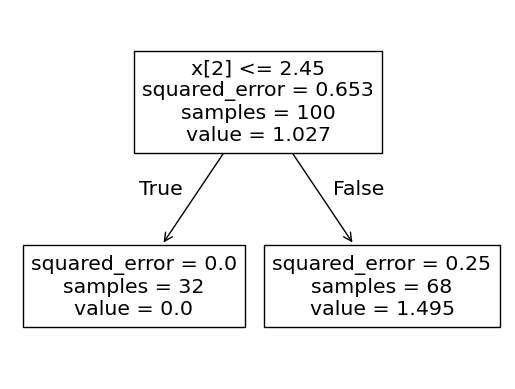

In [18]:
plot_tree(trees_test[0])

[Text(0.5, 0.75, 'x[3] <= 0.8\nsquared_error = 0.673\nsamples = 98\nvalue = 0.993'),
 Text(0.25, 0.25, 'squared_error = 0.0\nsamples = 32\nvalue = 0.0'),
 Text(0.375, 0.5, 'True  '),
 Text(0.75, 0.25, 'squared_error = 0.25\nsamples = 66\nvalue = 1.505'),
 Text(0.625, 0.5, '  False')]

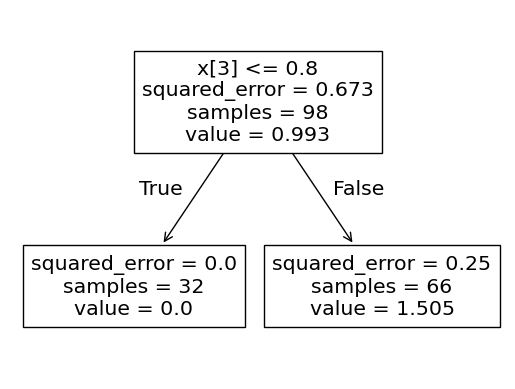

In [19]:
plot_tree(trees_test[1])

In [20]:
print(f'             |X[{tst.root.feature}] <= {tst.root.threshold:.2f}|')
print('                   /\\')
print(f'     |X[{tst.root.left.feature}] <= {tst.root.left.threshold:.2f}|  |X[{tst.root.right.feature}] <= {tst.root.right.threshold:.2f}|')
print('           /\\              /\\')
print(f'     |{tst.root.left.left.value:.2f}|  |{tst.root.left.right.value:.2f}|  |{tst.root.right.left.value:.2f}|  |{tst.root.right.right.value:.2f}|')

             |X[2] <= 2.45|
                   /\
     |X[3] <= 0.80|  |X[3] <= 0.80|
           /\              /\
     |0.00|  |1.51|  |0.00|  |1.51|


In [21]:
obs = X[111]
prediction = tst.predict(obs)

print(f'For obs = {obs} | {prediction:.2f}')

obs = X[1]
prediction = tst.predict(obs)

print(f'For obs = {obs} | {prediction:.2f}')

For obs = [6.4 2.7 5.3 1.9] | 1.51
For obs = [4.9 3.  1.4 0.2] | 0.00
